# A LITTLLE TRY TO PLOT GRAPH ON MAP

In [4]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

# Opening Alliance dataset

In [2]:
alliance = pd.read_csv('data/Alliance-Dataset.csv', sep=';', encoding='utf-8', engine='python')
alliance.head()

,Alliance,Airline
0,Star Alliance,Adria Airways
1,Star Alliance,Aegean Airlines
2,Star Alliance,Air Canada
3,Star Alliance,Air China
4,Star Alliance,Air New Zealand


# Opening Airport Dataset

In [3]:
airport = pd.read_csv('data/airports.dat', sep=',', encoding='utf-8', header=None)
airport.columns=['AirportID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST', 'TimeZone', 'Type', 'Source']
airport.head()

,AirportID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,TimeZone,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


# Opening Routes Dataset

In [4]:
routes = pd.read_csv('data/routes.dat', sep=',', encoding='utf-8', engine='python')
routes.columns = ['Airline','Airline ID','Source Airport','Source Airport ID','Destination Airport','Destination Airport ID','Codeshare','Stops','Equipment']
routes.head()

,Airline,Airline ID,Source Airport,Source Airport ID,Destination Airport,Destination Airport ID,Codeshare,Stops,Equipment
0,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
2,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
3,2B,410,CEK,2968,OVB,4078,NaN,0,CR2
4,2B,410,DME,4029,KZN,2990,NaN,0,CR2


# Create visualisation where each airport is on the world map

https://towardsdatascience.com/catching-that-flight-visualizing-social-network-with-networkx-and-basemap-ce4a0d2eaea6

In [5]:
# preprocess data

condenced_routes = routes[['Source Airport','Destination Airport']]
condenced_routes = pd.DataFrame(condenced_routes.groupby(['Source Airport', 'Destination Airport']).size().reset_index(name='Number of flights'))
condenced_routes.head()

position = airport[['IATA','Name','Latitude','Longitude','ICAO']]
position.head()

,IATA,Name,Latitude,Longitude,ICAO
0,GKA,Goroka Airport,-6.081690,145.391998,AYGA
1,MAG,Madang Airport,-5.207080,145.789001,AYMD
2,HGU,Mount Hagen Kagamuga Airport,-5.826790,144.296005,AYMH
3,LAE,Nadzab Airport,-6.569803,146.725977,AYNZ
4,POM,Port Moresby Jacksons International Airport,-9.443380,147.220001,AYPY


In [6]:
graph = nx.from_pandas_edgelist(condenced_routes, source = 'Source Airport', target = 'Destination Airport', edge_attr = 'Number of flights',create_using = nx.DiGraph())

In [39]:
plt.figure(figsize = (20,15))
m = Basemap(projection='mill',lon_0=180)

<Figure size 1440x1080 with 0 Axes>

In [40]:
mx, my = m(position['Longitude'].values, position['Latitude'].values)
pos = {}
for count, elem in enumerate (position['IATA']):
     pos[elem] = (mx[count], my[count])

In [58]:
truc = condenced_routes.merge(position, right_on='IATA', left_on='Source Airport', how='left')
list(truc[['Latitude']].values)

[array([36.82220078]),
 array([36.82220078]),
 array([36.82220078]),
 array([36.82220078]),
 array([36.82220078]),
 array([36.82220078]),
 array([36.82220078]),
 array([57.09275891]),
 array([57.09275891]),
 array([57.09275891]),
 array([57.09275891]),
 array([57.09275891]),
 array([57.09275891]),
 array([57.09275891]),
 array([57.09275891]),
 array([57.09275891]),
 array([57.09275891]),
 array([57.09275891]),
 array([57.09275891]),
 array([57.09275891]),
 array([24.26169968]),
 array([24.26169968]),
 array([45.0021019]),
 array([45.0021019]),
 array([45.0021019]),
 array([56.29999924]),
 array([56.29999924]),
 array([56.29999924]),
 array([56.29999924]),
 array([56.29999924]),
 array([56.29999924]),
 array([56.29999924]),
 array([56.29999924]),
 array([nan]),
 array([-19.5632]),
 array([16.19169998]),
 array([53.74000168]),
 array([53.74000168]),
 array([53.74000168]),
 array([53.74000168]),
 array([nan]),
 array([nan]),
 array([30.37109947]),
 array([30.37109947]),
 array([30.3710994

NetworkXError: Node 'AAT' has no position.

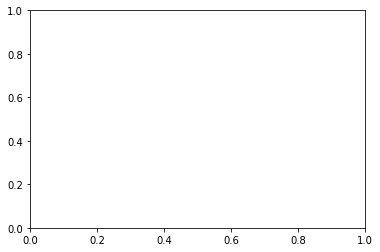

In [11]:
nx.draw_networkx_nodes(G = graph, pos = pos, node_list = graph.nodes(),node_color = 'r', alpha = 0.8, node_size = 100)
nx.draw_networkx_edges(G = graph, pos = pos, edge_color='g', alpha=0.2, arrows = False)

FileNotFoundError: [Errno 2] No such file or directory: './images/map_1.png'

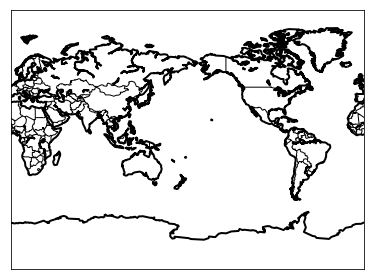

In [38]:
m.drawcountries(linewidth = 1)
m.drawcoastlines(linewidth=2)
plt.tight_layout()
plt.savefig("./images/map_1.png", format = "png", dpi = 300)
plt.show()

***
# Which part of the world is dominated by who, and what is a likely expansion?
- Each airline has a country of origin, and we can also associate each airport to a country. We then start the analysis by identifying the major alliance for each airport (for each airport count the number of edges for each alliance and attribute the airport to the alliance with the maximum count). We then have a graph with 3 labels, and nodes with an unknown label, if not served by an alliance company. A validation step of this approach is then to see whether the country of the airport is the same as the country of one of the airlines inside the alliance (some countries have airlines belonging to different alliances, but that should not matter). When plotting the result on the worldmap, we might see geographic differences between the alliances.

### Loading data (from Nicolas Notebook)

In [113]:
# routes
routes = pd.read_csv('data/routes.dat', sep=',', encoding='utf-8')
routes.columns = ['Airline','AirlineID','SourceAirport','SourceAirportID','DestinationAirport','DestinationAirportID','Codeshare','Stops','Equipment']

# airlines
airlines = pd.read_csv('data/airlines.dat', sep=',', encoding='utf-8')
airlines.columns = ['AirlineID', 'Name', 'Alias',  'IATA', 'ICAO','Callsign','Country','Active']

# airports
airports = pd.read_csv('data/airports.dat', sep=',', encoding='utf-8')
airports.columns = ['AirportID', 'Name', 'City', 'Country', 'IATA', 'ICAO','Latitude','Longitude','Altitude', 'Timezone','DST', 'TzdatabaseTimeZone', 'Type', 'Source']

# alliances
alliances = pd.read_csv('data/alliances.dat', sep=',', encoding='utf-8')

### Creating the DataFrames corresponding to the work expected

In [114]:
# Airlines country DataFrame
airl_alliances  = pd.merge(alliances, airlines, left_on='Airline', right_on='Name', how = 'left')[['Alliance', 'Name', 'IATA', 'Country']]
# correct error of dataset
airl_alliances.loc[8].Country= 'Colombia'
airl_alliances

,Alliance,Name,IATA,Country
0,Star Alliance,Adria Airways,JP,Slovenia
1,Star Alliance,Aegean Airlines,A3,Greece
2,Star Alliance,Air Canada,AC,Canada
3,Star Alliance,Air China,CA,China
4,Star Alliance,Air New Zealand,NZ,New Zealand
5,Star Alliance,All Nippon Airways,NH,Japan
6,Star Alliance,Asiana Airlines,OZ,Republic of Korea
7,Star Alliance,Austrian Airlines,OS,Austria
8,Star Alliance,Avianca - Aerovias Nacionales de Colombia,AV,Colombia
9,Star Alliance,Brussels Airlines,SN,Belgium


In [115]:
routes_alce = pd.merge(routes, airl_alliances, left_on = 'Airline', right_on = 'IATA', how = 'left')
routes_alce_only = routes_alce[~routes_alce.IATA.isnull()]
routes_alce_only.head(2)

,Airline,AirlineID,SourceAirport,SourceAirportID,DestinationAirport,DestinationAirportID,Codeshare,Stops,Equipment,Alliance,Name,IATA,Country
4237,A3,96,AOK,1459,ATH,3941,NaN,0,DH4,Star Alliance,Aegean Airlines,A3,Greece
4238,A3,96,AOK,1459,KSJ,1461,NaN,0,DH8,Star Alliance,Aegean Airlines,A3,Greece


### Plot world map with color according to airline country base

ColorCode :
- 1 if Star Alliance only
- 2 if One World only
- 3 if SkyTeam only
- 4 if Star Alliance and One World
- 5 if One World and SkyTeam
- 6 if SkyTeam and Star Alliance
- 7 if all

In [118]:
# For countries of airlines of alliances
country_attribution = pd.DataFrame(data={'Country': [], 'ColorCode': []});
for country in airl_alliances.Country.unique():
    alliances = airl_alliances[airl_alliances.Country==country].Alliance.unique()
    if 'Star Alliance' in alliances:
        if 'One World' in alliances:
            if 'SkyTeam' in alliances :
                colorCode = 7
            else :
                colorCode = 4
        elif 'SkyTeam' in alliances :
            coloCode = 6
        else :
            colorCode = 1
    elif 'One World' in alliances :
        if 'SkyTeam' in alliances :
            colorCode = 5
        else :
            colorCode = 2
    elif 'SkyTeam' in alliances :
        colorCode = 3
    country_attribution = country_attribution.append({'Country':country, 'ColorCode':colorCode},ignore_index=True)

#some change to fit the country names of world map
country_attribution.rename(index={'China':"People's Republic of China",
                                  'Republic of Korea': 'South Korea',
                                  #'Singapore':,
                                  'United States':'United States of America'},
                                  #'Hong Kong SAR of China':}, 
                                   inplace=True)

country_attribution = country_attribution.set_index('Country')


In [119]:
country_attribution

,ColorCode
Country,
Slovenia,1.0
Greece,1.0
Canada,1.0
China,1.0
New Zealand,1.0
Japan,4.0
Republic of Korea,4.0
Austria,1.0
Colombia,1.0


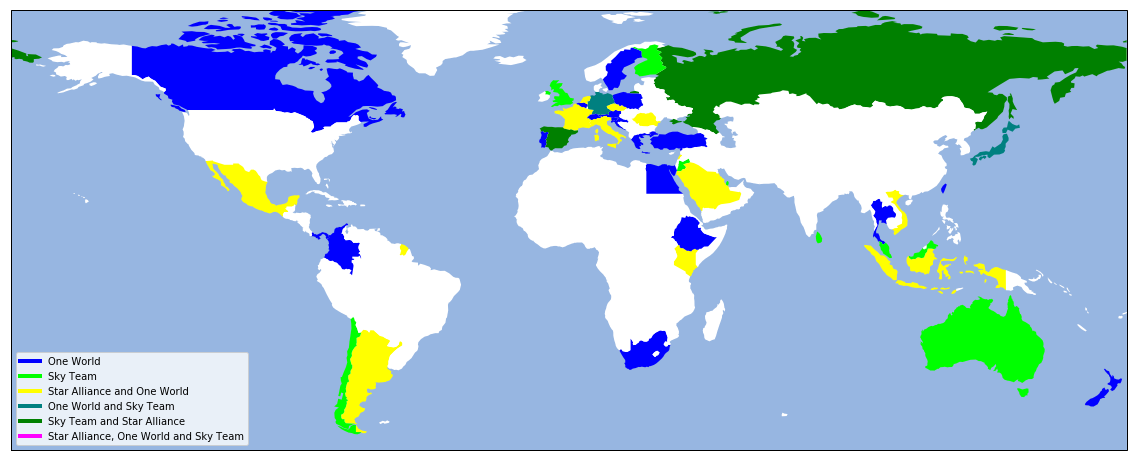

In [155]:
# plot world map
import cartopy
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs

plt.figure(figsize = (20,15))
ax = plt.axes(projection=ccrs.PlateCarree())
#ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
#ax.add_feature(cartopy.feature.COASTLINE)
#ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)
#ax.add_feature(cartopy.feature.LAKES, alpha=0.95)
#ax.add_feature(cartopy.feature.RIVERS)
ax.set_extent([-150, 60, -25, 60])

shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()


# 1 if Star Alliance only -> red
# 2 if One World only -> blue
# 3 if SkyTeam only -> green
# 4 if Star Alliance and One World
# 5 if One World and SkyTeam
# 6 if SkyTeam and Star Alliance
# 7 if all -> 
color_list=[(1,0,0),(0,0,1),(0,1,0),(1,1,0),(0,0.5,0.5),(0,0.5,0),(1,0,1)]

for country in countries:

    if country.attributes['NAME_EN'] in country_attribution.index :
        num=country_attribution.loc[country.attributes['NAME_EN']].ColorCode
        ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          facecolor=color_list[int(num)],
                          label=country.attributes['NAME_EN'])
    else :
        ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          facecolor=(1,1,1),
                          label=country.attributes['NAME_EN'])
    
#plt.legend(color, ["SA", "OW", "ST", "SA+OW", "OW+ST", "ST+SA", "SA+OW+ST"])

#LEGEND
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

SA='Star Alliance'
OW='One World'
ST='Sky Team'
name_list=[SA, OW, ST, SA+' and '+OW, OW+' and '+ST, ST+" and "+SA, SA+', '+OW+' and '+ST]

legend_elements=[]
for i in range (1,7):
    legend_elements.append(Line2D([0], [0], color=color_list[i], lw=4, label=name_list[i]))
plt.legend(handles=legend_elements, loc='lower left')
plt.show()
